# Lesson 1 - It's Batik Time

Indonesian Batik classification using Resnet34 and Resnet50

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [3]:
from fastai import *
from fastai.vision import *

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [4]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

We are going to use [Batik Dataset](https://github.com/agusekominarno/Batik/blob/master/Dataset/Batik300.zip). It is collected by capturing 50 types of Batik cloth. Each cloth is captured to as much as six random images and then resized to 128x128 pixels size in JPEG format. Total number of images in a dataset is 300 and consists of 50 classes. In general, there are two patterns of captured batik images, geometric and non-geometric patterns. Dataset provided by Laboratorium Komputasi Cerdas dan Visi, Institut Teknologi Sepuluh Nopember http://kcv.if.its.ac.id


In [5]:
path_img = Path('/mnt/mldata/data/Batik300')

In [6]:
help(path_img.ls)

Help on method <lambda> in module fastai.core:

<lambda> lambda (...) method of pathlib.PosixPath instance



In [45]:
!ls {path_img}

B10_1.jpg  B16_3.jpg  B23_1.jpg  B29_4.jpg  B3_5.jpg   B42_5.jpg  B49_1.jpg
B10_2.jpg  B16_4.jpg  B23_2.jpg  B29_5.jpg  B36_1.jpg  B42_6.jpg  B49_2.jpg
B10_3.jpg  B16_5.jpg  B23_3.jpg  B29_6.jpg  B36_2.jpg  B4_2.jpg   B49_3.jpg
B10_4.jpg  B16_6.jpg  B23_4.jpg  B30_1.jpg  B36_3.jpg  B43_1.jpg  B49_4.jpg
B10_5.jpg  B1_6.jpg   B23_5.jpg  B30_2.jpg  B36_4.jpg  B43_2.jpg  B49_5.jpg
B10_6.jpg  B17_1.jpg  B23_6.jpg  B30_3.jpg  B36_5.jpg  B43_3.jpg  B49_6.jpg
B11_1.jpg  B17_2.jpg  B2_3.jpg	 B30_4.jpg  B36_6.jpg  B43_4.jpg  B50_1.jpg
B11_2.jpg  B17_3.jpg  B24_1.jpg  B30_5.jpg  B3_6.jpg   B43_5.jpg  B50_2.jpg
B11_3.jpg  B17_4.jpg  B24_2.jpg  B30_6.jpg  B37_1.jpg  B43_6.jpg  B50_3.jpg
B11_4.jpg  B17_5.jpg  B24_3.jpg  B31_1.jpg  B37_2.jpg  B4_3.jpg   B50_4.jpg
B11_5.jpg  B17_6.jpg  B24_4.jpg  B31_2.jpg  B37_3.jpg  B44_1.jpg  B50_5.jpg
B11_6.jpg  B18_1.jpg  B24_5.jpg  B31_3.jpg  B37_4.jpg  B44_2.jpg  B50_6.jpg
B1_1.jpg   B18_2.jpg  B24_6.jpg  B31_4.jpg  B37_5.jpg  B44_3.jpg  B5_1.jpg
B12_1.jpg  B18

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html).

In [9]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/mnt/mldata/data/Batik300/B1_1.jpg'),
 PosixPath('/mnt/mldata/data/Batik300/B1_2.jpg'),
 PosixPath('/mnt/mldata/data/Batik300/B1_3.jpg'),
 PosixPath('/mnt/mldata/data/Batik300/B1_4.jpg'),
 PosixPath('/mnt/mldata/data/Batik300/B1_5.jpg')]

In [10]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [11]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs)
data.normalize(imagenet_stats)

In [15]:
help(create_cnn)

NameError: name 'create_cnn' is not defined

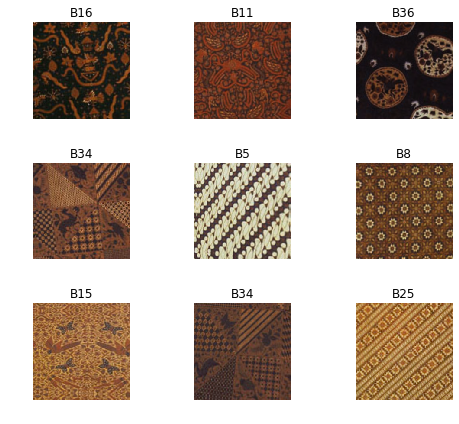

In [9]:
data.show_batch(rows=3, figsize=(7,6))

In [10]:
print(data.classes)
len(data.classes),data.c

['B1', 'B10', 'B11', 'B12', 'B13', 'B14', 'B15', 'B16', 'B17', 'B18', 'B19', 'B2', 'B20', 'B21', 'B22', 'B23', 'B24', 'B25', 'B26', 'B27', 'B28', 'B29', 'B3', 'B30', 'B31', 'B32', 'B33', 'B34', 'B35', 'B36', 'B37', 'B38', 'B39', 'B4', 'B40', 'B41', 'B42', 'B43', 'B44', 'B45', 'B46', 'B47', 'B48', 'B49', 'B5', 'B50', 'B6', 'B7', 'B8', 'B9']


(50, 50)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [11]:
learn = ConvLearner(data, models.resnet34, metrics=error_rate)

In [12]:
learn.fit_one_cycle(4)

Total time: 00:07
epoch  train_loss  valid_loss  error_rate
1      4.467336    3.778867    0.896552    (00:02)
2      3.572202    2.624265    0.379310    (00:01)
3      2.656308    1.465506    0.189655    (00:01)
4      2.097410    0.998969    0.120690    (00:01)



In [13]:
learn.save('stage-1')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [14]:
interp = ClassificationInterpretation.from_learner(learn)

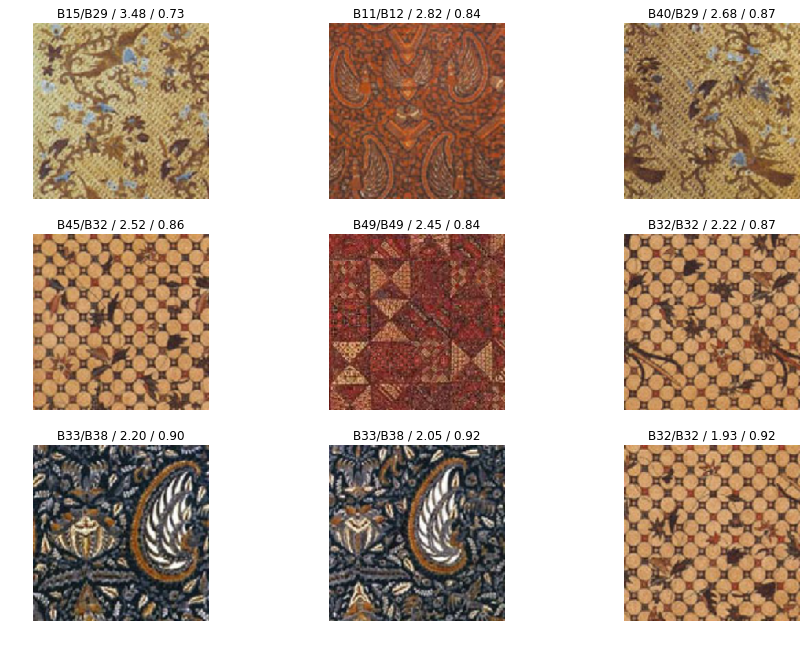

In [15]:
interp.plot_top_losses(9, figsize=(15,11))

In [17]:
doc(interp.plot_top_losses)

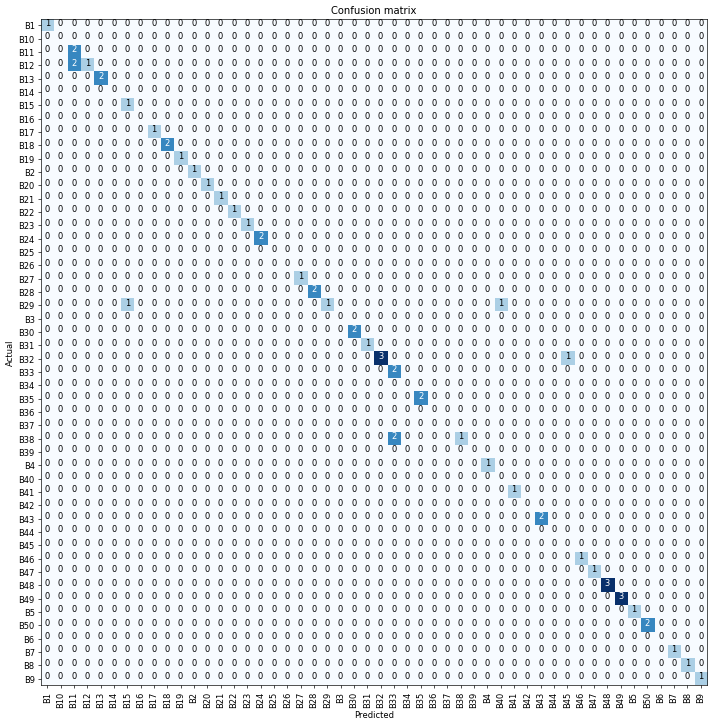

In [16]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [17]:
interp.most_confused(min_val=1)

[('B12', 'B11', 2), ('B38', 'B33', 2)]

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [18]:
learn.unfreeze()

In [19]:
learn.fit_one_cycle(1)

Total time: 00:02
epoch  train_loss  valid_loss  error_rate
1      0.714652    0.959540    0.068965    (00:02)



In [20]:
learn.load('stage-1')

In [21]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


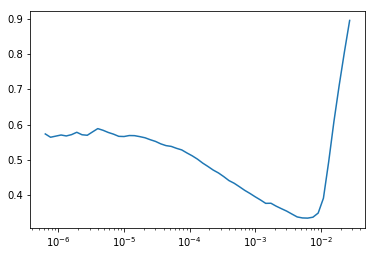

In [22]:
learn.recorder.plot()

In [23]:
learn.unfreeze()
learn.fit_one_cycle(8, max_lr=slice(1e-6,6e-3))

Total time: 00:15
epoch  train_loss  valid_loss  error_rate
1      0.613298    0.515241    0.051724    (00:01)
2      0.456771    0.094958    0.000000    (00:01)
3      0.330804    0.031220    0.017241    (00:01)
4      0.255792    0.009000    0.000000    (00:01)
5      0.200038    0.007120    0.000000    (00:01)
6      0.164091    0.001719    0.000000    (00:01)
7      0.136914    0.001399    0.000000    (00:01)
8      0.116217    0.001593    0.000000    (00:01)



That's not only a pretty accurate model, but it's perfect model! :-)

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. Later in the course you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network might eat up our GPU memory.

In [24]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=320, bs=bs//2)
data.normalize(imagenet_stats)

In [25]:
learn = ConvLearner(data, models.resnet50, metrics=error_rate)

In [26]:
learn.fit_one_cycle(8, max_lr=slice(1e-3))

Total time: 00:35
epoch  train_loss  valid_loss  error_rate
1      4.368554    3.599138    0.928571    (00:09)
2      3.324011    1.984672    0.250000    (00:03)
3      2.340815    0.477174    0.000000    (00:03)
4      1.711936    0.123398    0.000000    (00:03)
5      1.313343    0.053079    0.000000    (00:03)
6      1.037735    0.035568    0.000000    (00:03)
7      0.836728    0.030329    0.000000    (00:03)
8      0.689668    0.029706    0.000000    (00:03)



In [27]:
learn.save('stage-1-50')

It achieved also error rate of 0%. It's already perfect, actually no need to unfreeze, but let's try it also

In [28]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

Total time: 00:16
epoch  train_loss  valid_loss  error_rate
1      0.115509    0.030608    0.000000    (00:06)
2      0.115148    0.022865    0.000000    (00:04)
3      0.108565    0.019743    0.000000    (00:04)



It is a perfect error rate of 0% :-)

In [29]:
learn.save('stage-2-50')

In [30]:
interp = ClassificationInterpretation.from_learner(learn)

In [31]:
interp.most_confused(min_val=1)

[]

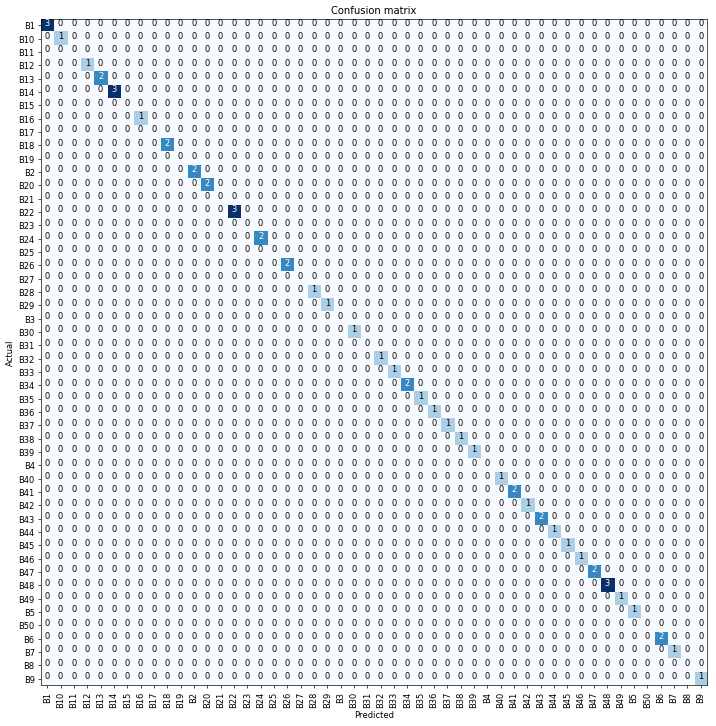

In [32]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

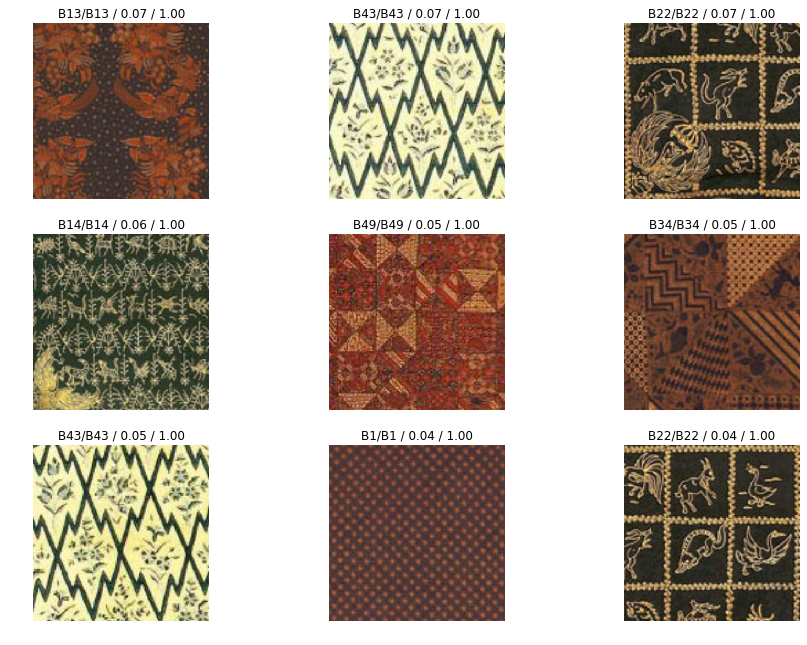

In [33]:
interp.plot_top_losses(9, figsize=(15,11))